<a href="https://colab.research.google.com/github/shaheerzubery/Deeplearning/blob/main/OBJECT_DETECTION_USING_DL_CNN_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install --upgrade tensorflow

In [2]:
import tensorflow 
from tensorflow import keras
print("Tensor FLow version",tensorflow.__version__)
print("Keras version", keras.__version__)

Tensor FLow version 2.9.0
Keras version 2.9.0


Explore data

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

%matplotlib inline

#image are in the folder
data = '/content/drive/MyDrive/shapes'
classes = os.listdir(data)
classes.sort()
print(len(classes), 'classes')
print(classes)

3 classes
['circle', 'square', 'triangle']


## **Plot the classes**

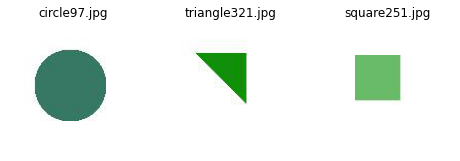

In [4]:
fig = plt.figure(figsize= (8,10))
i = 0
for sub_dir in os.listdir(data):
    i+=1
    img_file = os.listdir(os.path.join(data,sub_dir))[0]
    img_path = os.path.join(data, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## Prepare data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128,128)
batch_size = 30

print("Getting Data ...")
datagen = ImageDataGenerator(rescale = 1/255, #normalize the pixel
                             validation_split = 0.30) 

print("Preparing training dataset ..")

train_generate = datagen.flow_from_directory(
    data,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"
)

print("preparing for validation ..")

val_generate = datagen.flow_from_directory(
    data,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

classnames = list(train_generate.class_indices.keys())
print('data generated ready')



Getting Data ...
Preparing training dataset ..
Found 847 images belonging to 3 classes.
preparing for validation ..
Found 363 images belonging to 3 classes.
data generated ready


**CNC MODEL**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

model  = Sequential()

model.add(Conv2D(32,(6,6), input_shape = train_generate.image_shape, activation = 'relu'))
model.add((MaxPool2D(pool_size = (2,2))))

model.add(Conv2D(32,(6,6), activation = 'relu'))
model.add((MaxPool2D(pool_size = (2,2))))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

#flatten layer flattern the feature map

model.add(Flatten())
# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)

model.add(Dense(train_generate.num_classes, activation = "softmax"))
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 flatten (Flatten)           (None, 25088)             0

# **Train a Model**

In [7]:
num_epochs = 5
history = model.fit(
    train_generate,
    steps_per_epoch = train_generate.samples // batch_size,
    validation_data = val_generate, 
    validation_steps = val_generate.samples // batch_size,
    epochs = num_epochs
)

Epoch 1/5
28/28 [==============================] - 41s 1s/step - loss: 1.0672 - accuracy: 0.4896 - val_loss: 0.6736 - val_accuracy: 0.7444
Epoch 2/5
28/28 [==============================] - 35s 1s/step - loss: 0.4463 - accuracy: 0.8152 - val_loss: 0.3671 - val_accuracy: 0.8333
Epoch 3/5
28/28 [==============================] - 35s 1s/step - loss: 0.2659 - accuracy: 0.8960 - val_loss: 0.1758 - val_accuracy: 0.9528
Epoch 4/5
28/28 [==============================] - 34s 1s/step - loss: 0.1545 - accuracy: 0.9461 - val_loss: 0.0928 - val_accuracy: 0.9750
Epoch 5/5
28/28 [==============================] - 34s 1s/step - loss: 0.0773 - accuracy: 0.9841 - val_loss: 0.0450 - val_accuracy: 0.9944


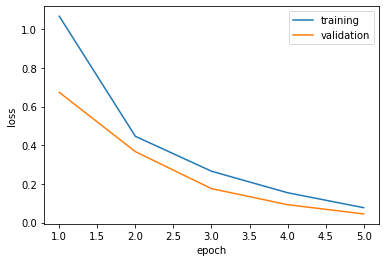

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...
1/1 [==============================] - 0s 279ms/step


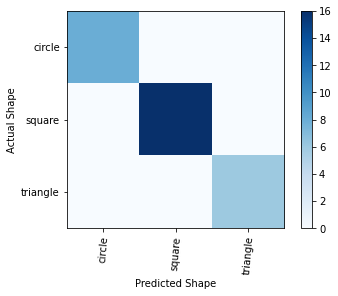

In [12]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = val_generate[0][0]
y_test = val_generate[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()